In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import constants, iceberg, metocean, drift, tools, simulator, test_case, plot

# Setup Initial Conditions and Reference Track

In [5]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats

# Run Test Simulation

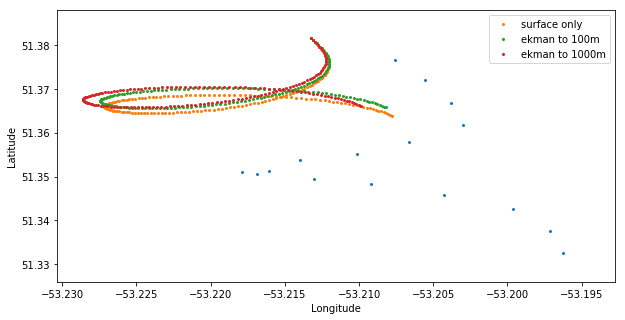

In [3]:
xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

fig = plt.figure(figsize=(10, 5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(ref_lons, ref_lats, s=4)

xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=False)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='surface only')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 100m')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                                start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True,
                                depth_vec=np.arange(0, -1100, -100))

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 1000m')


plt.legend()
plt.show()

# Optimize Ca and Cw

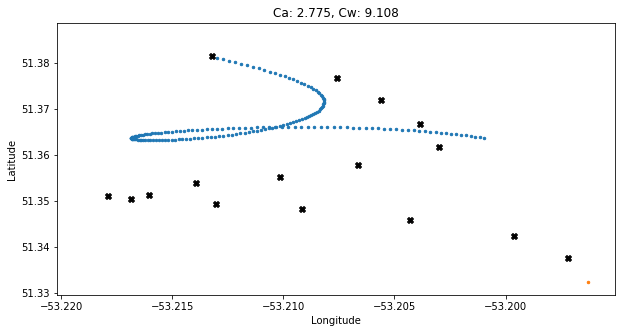

In [6]:
optimization_result_list = []
with PdfPages('plots/optim_steps2.pdf') as pdf:
    for i in range(len(ref_lons) - 2, len(ref_lons) - 1):
        bounds = ((0, 10), (0, 10))
        optimization_result = simulator.run_optimization((ref_lats[:i+1], ref_lons[:i+1]), 
                                                         (start_latitude, start_longitude), 
                                                         (start_time, ref_times[i+1] + np.timedelta64(6, 'h')), 
                                                         bounds=bounds)
        optimization_result_list.append(optimization_result)
        Ca, Cw = optimization_result.x

        xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                                  start_velocity=start_velocity, Ca=Ca, Cw=Cw)

        fig = plt.figure(figsize=(10, 5))
        plt.title('Ca: {}, Cw: {}'.format(round(Ca, 3), round(Cw, 3)))
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.scatter(xds['longitude'], xds['latitude'], s=6)
        plt.scatter(ref_lons, ref_lats, s=6)
        plt.scatter(ref_lons[:i+1], ref_lats[:i+1], marker='X', c='black')
        plt.show()
        pdf.savefig(fig)

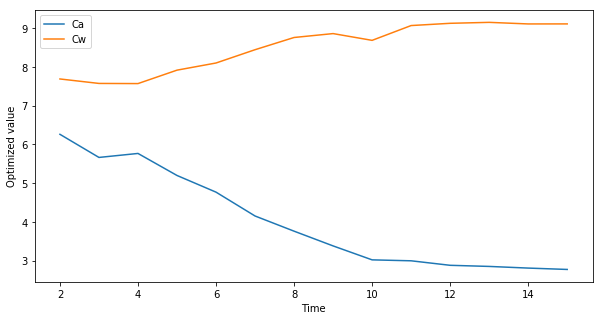

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, len(ref_lons) - 1), [res.x[0] for res in optimization_result_list], label='Ca')
plt.plot(range(2, len(ref_lons) - 1), [res.x[1] for res in optimization_result_list], label='Cw')
plt.ylabel('Optimized value')
plt.xlabel('Time')
plt.legend()
plt.show()

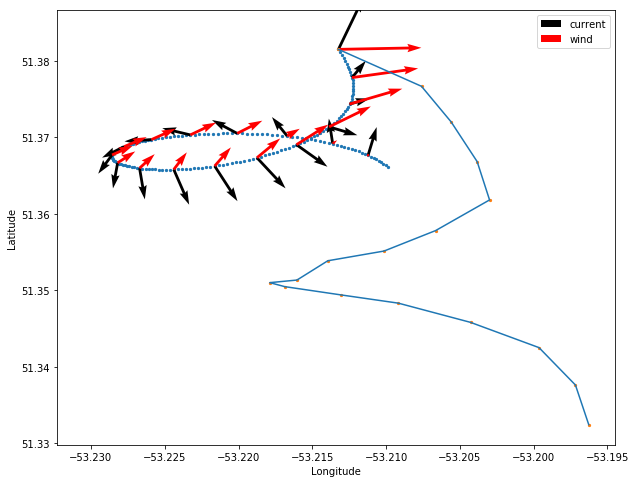

In [5]:
plot.plot_iceberg_track(xds['latitude'], xds['longitude'], 
                        vectors=[[xds['current_eastward_force'], xds['current_northward_force']],
                                 [xds['wind_eastward_force'], xds['wind_northward_force']]], 
                        arrow_colors=['black', 'red'],arrow_labels=['current', 'wind'],
                        ref_track=(ref_lats, ref_lons))

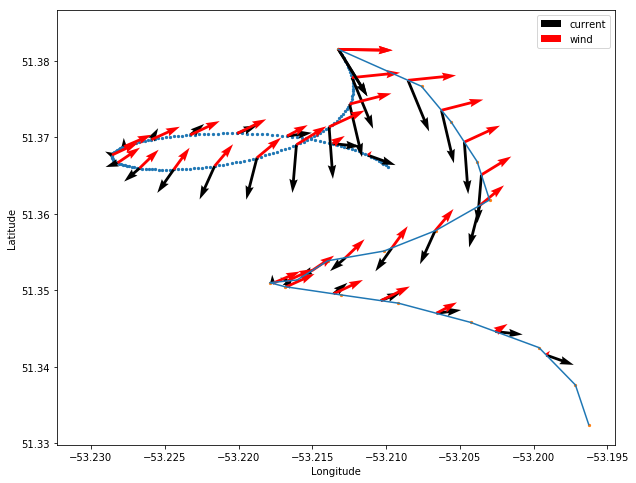

In [6]:
plot.plot_iceberg_track(xds['latitude'], xds['longitude'], 
                        vectors=[[xds['current_eastward_velocity'], xds['current_northward_velocity']],
                                 [xds['wind_eastward_velocity'], xds['wind_northward_velocity']]], 
                        arrow_colors=['black', 'red'],arrow_labels=['current', 'wind'],
                        ref_track=(ref_lats, ref_lons), quiver_ref_track=True)